# Fundamental factor models

By Evgenia "Jenny" Nitishinskaya, Delaney Granizo-Mackenzie, and Maxwell Margenot.

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)

Notebook released under the Creative Commons Attribution 4.0 License.

---

Fundamentals are data having to do with the asset issuer, like the sector, size, and expenses of the company. We can use this data to build a linear factor model, expressing returns on any asset as

$$R_t = a_t + b_{t1} F_1 + b_{t2} F_2 + \ldots + b_{tK} F_K + \epsilon_t$$

There are two different approaches to computing the factors $F_j$, which represent the returns associated with some fundamental characteristics, and the factor sensitivities $b_{tj}$.

##Approach 1: Portfolio Construction

In the first, we start by representing each characteristic of interest by a portfolio: we sort all assets by that characteristic, then build the portfolio by going long the top quantile of assets and short the bottom quantile. The factor corresponding to this characteristic is the return on this portfolio. Then, the $b_{ij}$ are estimated for each asset $i$ by regressing over the historical values of $R_i$ and of the factors.

We'll use the canonical Fama-French factors for this example, which are the returns of portfolios constructred based on fundamental factors.

We start by getting the fundamentals data for all assets and constructing the portfolios for each characteristic:

Import some libraries.

In [1]:
import numpy as np
import pandas as pd
from quantopian.pipeline.data import morningstar
import statsmodels.api as sm
from statsmodels import regression
import matplotlib.pyplot as plt
import scipy.stats

Set the date range for which we want data.

In [2]:
start_date = '2011-1-1'
end_date = '2012-1-1'

###Using the Pipeline API to Fetch Data

The pipeline API is a very useful tool for factor analysis. We use it here to get data for our analysis. Specifically, we want the daily values of book to price ratio and market cap for every security. But we also do several other useful filtering steps which are detailed in code comments.

In [3]:
import numpy as np
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.factors import CustomFactor, Returns

# Here's the raw data we need, everything else is derivative.

class MarketCap(CustomFactor):
    # Here's the data we need for this factor
    inputs = [morningstar.valuation.shares_outstanding, USEquityPricing.close]
    # Only need the most recent values for both series
    window_length = 1
    
    def compute(self, today, assets, out, shares, close_price):
        # Shares * price/share = total price = market cap
        out[:] = shares * close_price
        
        
class BookToPrice(CustomFactor):
    # pb = price to book, we'll need to take the reciprocal later
    inputs = [morningstar.valuation_ratios.pb_ratio]
    window_length = 1
    
    def compute(self, today, assets, out, pb):
        out[:] = 1 / pb
        
def make_pipeline():
    """
    Create and return our pipeline.
    
    We break this piece of logic out into its own function to make it easier to
    test and modify in isolation.
    
    In particular, this function can be copy/pasted into research and run by itself.
    """
    pipe = Pipeline()

    # Add our factors to the pipeline
    market_cap = MarketCap()
    # Raw market cap and book to price data gets fed in here
    pipe.add(market_cap, "market_cap")
    book_to_price = BookToPrice()
    pipe.add(book_to_price, "book_to_price")
    
    # We also get daily returns
    returns = Returns(inputs=[USEquityPricing.close], window_length=2)
    pipe.add(returns, "returns")
    
    # We compute a daily rank of both factors, this is used in the next step,
    # which is computing portfolio membership.
    market_cap_rank = market_cap.rank()
    pipe.add(market_cap_rank, 'market_cap_rank')
    
    book_to_price_rank = book_to_price.rank()
    pipe.add(book_to_price_rank, 'book_to_price_rank')

    # Build Filters representing the top and bottom 1000 stocks by our combined ranking system.
    biggest = market_cap_rank.top(1000)
    smallest = market_cap_rank.bottom(1000)
    
    highpb = book_to_price_rank.top(1000)
    lowpb = book_to_price_rank.bottom(1000)
    
    # Don't return anything not in this set, as we don't need it.
    pipe.set_screen(biggest | smallest | highpb | lowpb)
    
    # Add the boolean flags we computed to the output data
    pipe.add(biggest, 'biggest')
    pipe.add(smallest, 'smallest')
    
    pipe.add(highpb, 'highpb')
    pipe.add(lowpb, 'lowpb')
    
    return pipe

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:11: NotAllowedInLiveWarning: The fundamentals attribute valuation.shares_outstanding is not yet allowed in broker-backed live trading


Now we initialize the pipeline.

In [4]:
pipe = make_pipeline()

We can visualize the dependency graph of our data computations here.

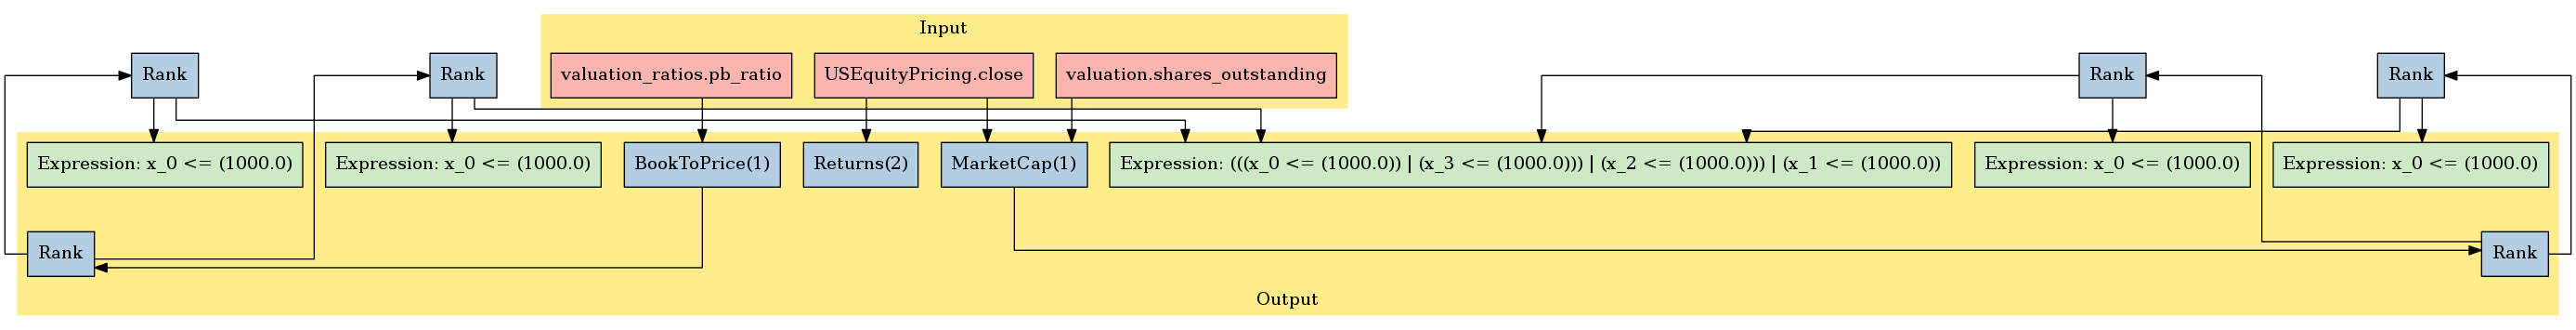

In [5]:
pipe.show_graph('png')

This function will allow us to run the pipeline.

In [6]:
from quantopian.research import run_pipeline

Now let's actually run it and check out our results.

In [7]:
# This takes a few minutes.
results = run_pipeline(pipe, start_date, end_date)
results

biggest  book_to_price  \
2011-01-03 00:00:00+00:00 Equity(2 [AA])          True       0.991867   
                          Equity(21 [AAME])      False       2.052967   
                          Equity(24 [AAPL])       True       0.167400   
                          Equity(31 [ABAX])      False       0.257898   
                          Equity(37 [ABCW])      False       0.277500   
                          Equity(51 [ABL])       False       2.364066   
                          Equity(53 [ABMD])      False       0.235200   
                          Equity(58 [SERV])      False       1.666944   
                          Equity(62 [ABT])        True       0.297699   
                          Equity(64 [ABX])        True       0.344994   
                          Equity(67 [ADSK])       True       0.193900   
                          Equity(76 [TAP])        True       0.857633   
                          Equity(88 [ACI])        True       0.460893   
                          Equity(100 [IEP])      False       1.077354   
                          Equity(106 [ACU])      False       0.853315   
                          Equity(107 [ACV])       True       0.360101   
                          Equity(112 [ACY])      False       1.571092   
                          Equity(114 [ADBE])      True       0.367202   
                          Equity(117 [AEY])      False       0.949668   
                          Equity(122 [ADI])       True       0.301296   
                          Equity(128 [ADM])       True       0.829669   
                          Equity(154 [AEM])       True       0.267001   
                          Equity(157 [AEG])       True       3.364738   
                          Equity(161 [AEP])       True       0.798722   
                          Equity(166 [AES])       True       0.808669   
                          Equity(168 [AET])       True       0.843526   
                          Equity(185 [AFL])       True       0.458695   
                          Equity(197 [AGCO])      True       0.602011   
                          Equity(205 [AGN])       True       0.221602   
                          Equity(216 [HES])       True       0.683620   
...                                                ...            ...   
2012-01-03 00:00:00+00:00 Equity(41919 [ORIG])   False       1.866368   
                          Equity(41978 [BLMT])   False       1.360174   
                          Equity(42000 [ASBB])   False       1.768659   
                          Equity(42023 [XYL])     True       0.386100   
                          Equity(42027 [UBNT])   False       0.044800   
                          Equity(42037 [ZLTQ])   False       0.244200   
                          Equity(42060 [LMOS])   False       0.161301   
                          Equity(42080 [BUR])    False       0.048900   
                          Equity(42091 [ACHC])   False       0.300996   
                          Equity(42112 [GEVA])   False       0.158200   
                          Equity(42118 [GRPN])    True       0.052900   
                          Equity(42125 [VAC])    False       1.952362   
                          Equity(42131 [IMPV])   False       0.100400   
                          Equity(42147 [NLNK])   False       0.253698   
                          Equity(42165 [INVN])   False       0.204801   
                          Equity(42173 [DLPH])    True       0.238698   
                          Equity(42175 [ANGI])   False       0.050000   
                          Equity(42176 [FBIO])   False       0.158200   
                          Equity(42181 [DDMG])   False       0.123000   
                          Equity(42183 [IMI])    False       0.221298   
                          Equity(42184 [MFRM])   False       0.001700   
                          Equity(42217 [TAS])    False       0.160100   
                          Equity(42230 [TRIP])   False       0.087200   
                          Equity

Great, we have all the data. Now we need to compute the returns of our portfolios over time. We have the daily returns for each equity, plus whether or not that equity was included in any given portfolio on any given day. We can combine that information in the following way to yield daily portfolio returns.

Step 1: Subset our results into only data belonging to our 'biggest' portfolio.

In [8]:
results[results.biggest]

biggest  book_to_price  \
2011-01-03 00:00:00+00:00 Equity(2 [AA])          True       0.991867   
                          Equity(24 [AAPL])       True       0.167400   
                          Equity(62 [ABT])        True       0.297699   
                          Equity(64 [ABX])        True       0.344994   
                          Equity(67 [ADSK])       True       0.193900   
                          Equity(76 [TAP])        True       0.857633   
                          Equity(88 [ACI])        True       0.460893   
                          Equity(107 [ACV])       True       0.360101   
                          Equity(114 [ADBE])      True       0.367202   
                          Equity(122 [ADI])       True       0.301296   
                          Equity(128 [ADM])       True       0.829669   
                          Equity(154 [AEM])       True       0.267001   
                          Equity(157 [AEG])       True       3.364738   
                          Equity(161 [AEP])       True       0.798722   
                          Equity(166 [AES])       True       0.808669   
                          Equity(168 [AET])       True       0.843526   
                          Equity(185 [AFL])       True       0.458695   
                          Equity(197 [AGCO])      True       0.602011   
                          Equity(205 [AGN])       True       0.221602   
                          Equity(216 [HES])       True       0.683620   
                          Equity(239 [AIG])       True       1.587554   
                          Equity(273 [ALU])       True       0.502790   
                          Equity(300 [ALK])       True       0.530110   
                          Equity(328 [ALTR])      True       0.175399   
                          Equity(337 [AMAT])      True       0.456809   
                          Equity(338 [BEAM])      True       0.614288   
                          Equity(351 [AMD])       True       0.123499   
                          Equity(353 [AME])       True       0.264201   
                          Equity(357 [TWX])       True       1.008980   
                          Equity(368 [AMGN])      True       0.483489   
...                                                ...            ...   
2012-01-03 00:00:00+00:00 Equity(38965 [FTNT])    True       0.106000   
                          Equity(39053 [CIT])     True       1.269680   
                          Equity(39073 [CIE])     True       0.345698   
                          Equity(39095 [CHTR])    True       0.071400   
                          Equity(39347 [ST])      True       0.225301   
                          Equity(39495 [SDRL])    True       0.385104   
                          Equity(39499 [VIP])     True       0.916003   
                          Equity(39546 [LYB])     True       0.572705   
                          Equity(39612 [SIX])     True       0.338799   
                          Equity(39778 [QEP])     True       0.637308   
                          Equity(39994 [NXPI])    True       0.295902   
                          Equity(40338 [SMFG])    True       1.660302   
                          Equity(40445 [LPLA])    True       0.407997   
                          Equity(40573 [FRC])     True       0.635809   
                          Equity(40616 [MMI])     True       0.434707   
                          Equity(40755 [NLSN])    True       0.433896   
                          Equity(40852 [KMI])     True       0.128500   
                          Equity(41047 [HCA])     True            NaN   
                          Equity(41150 [APO])     True       0.160800   
                          Equity(41242 [ARCO])    True       0.157801   
                          Equity(41416 [KOS])     True       0.213502   
                          Equity(41451 [LNKD])    True       0.097700   
                          Equity(41462 [MOS])     True       0.526704   
                          Equity

Step 2: Get returns.

In [9]:
results[results.biggest]['returns']

2011-01-03 00:00:00+00:00  Equity(2 [AA])          0.013083
                           Equity(24 [AAPL])      -0.003769
                           Equity(62 [ABT])        0.007778
                           Equity(64 [ABX])        0.011217
                           Equity(67 [ADSK])      -0.014952
                           Equity(76 [TAP])       -0.004362
                           Equity(88 [ACI])       -0.005954
                           Equity(107 [ACV])      -0.000270
                           Equity(114 [ADBE])      0.006869
                           Equity(122 [ADI])      -0.007638
                           Equity(128 [ADM])       0.007028
                           Equity(154 [AEM])       0.002354
                           Equity(157 [AEG])       0.008210
                           Equity(161 [AEP])      -0.002495
                           Equity(166 [AES])      -0.002048
                           Equity(168 [AET])       0.002628
                           Equity(185 [A

Step 3: Group by day and take the mean. This is pretty deep into pandas logic, so if you don't understand this on first pass it is recommended to check out pandas' documentation on all the functions used. Especially `groupby`, which is very useful. Keep in mind that the index in our results is a `MultiIndex` rather than a regular `Index`, that can complicate things.

In [10]:
results[results.biggest]['returns'].groupby(level=0).mean()

2011-01-03 00:00:00+00:00   -0.000173
2011-01-04 00:00:00+00:00    0.010987
2011-01-05 00:00:00+00:00   -0.005017
2011-01-06 00:00:00+00:00    0.004201
2011-01-07 00:00:00+00:00   -0.003209
2011-01-10 00:00:00+00:00   -0.001847
2011-01-11 00:00:00+00:00    0.000640
2011-01-12 00:00:00+00:00    0.006782
2011-01-13 00:00:00+00:00    0.009905
2011-01-14 00:00:00+00:00   -0.000804
2011-01-18 00:00:00+00:00    0.005200
2011-01-19 00:00:00+00:00    0.004477
2011-01-20 00:00:00+00:00   -0.012755
2011-01-21 00:00:00+00:00   -0.006107
2011-01-24 00:00:00+00:00    0.000013
2011-01-25 00:00:00+00:00    0.007606
2011-01-26 00:00:00+00:00   -0.001106
2011-01-27 00:00:00+00:00    0.009396
2011-01-28 00:00:00+00:00    0.003167
2011-01-31 00:00:00+00:00   -0.017886
2011-02-01 00:00:00+00:00    0.009216
2011-02-02 00:00:00+00:00    0.016059
2011-02-03 00:00:00+00:00   -0.001468
2011-02-04 00:00:00+00:00    0.003532
2011-02-07 00:00:00+00:00    0.002991
2011-02-08 00:00:00+00:00    0.005747
2011-02-09 0

Now run through this computation for each portfolio and get our final results.

In [11]:
R_biggest = results[results.biggest]['returns'].groupby(level=0).mean()
R_smallest = results[results.smallest]['returns'].groupby(level=0).mean()

R_highpb = results[results.highpb]['returns'].groupby(level=0).mean()
R_lowpb = results[results.lowpb]['returns'].groupby(level=0).mean()

SMB = R_smallest - R_biggest
HML = R_highpb - R_lowpb

What were the daily returns?

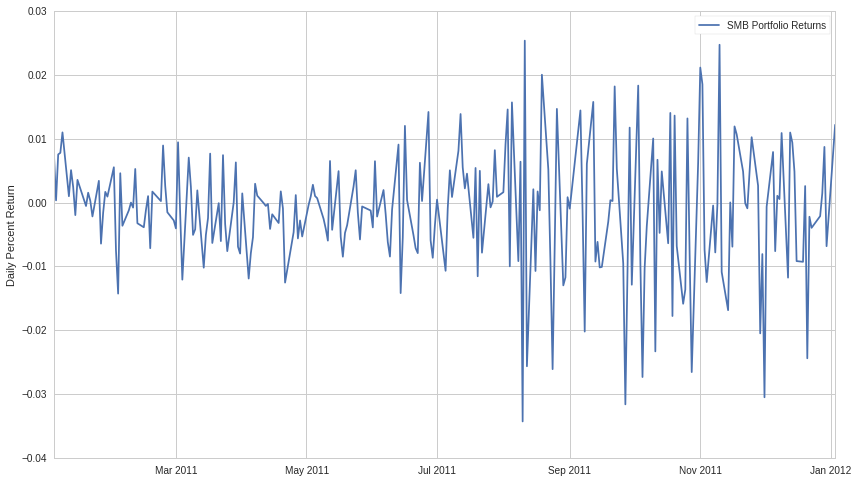

In [12]:
plt.plot(SMB.index, SMB.values)
plt.ylabel('Daily Percent Return')
plt.legend(['SMB Portfolio Returns']);

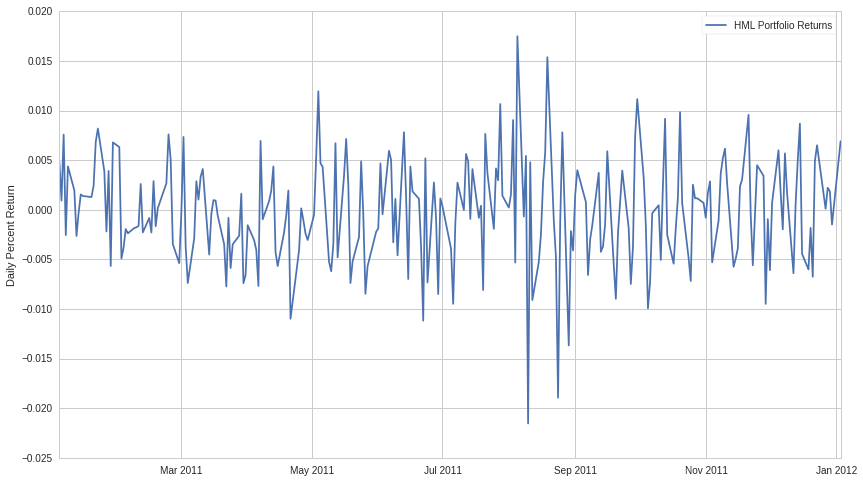

In [13]:
plt.plot(HML.index, HML.values)
plt.ylabel('Daily Percent Return')
plt.legend(['HML Portfolio Returns']);

And what would it look like to hold these portfolios over time?

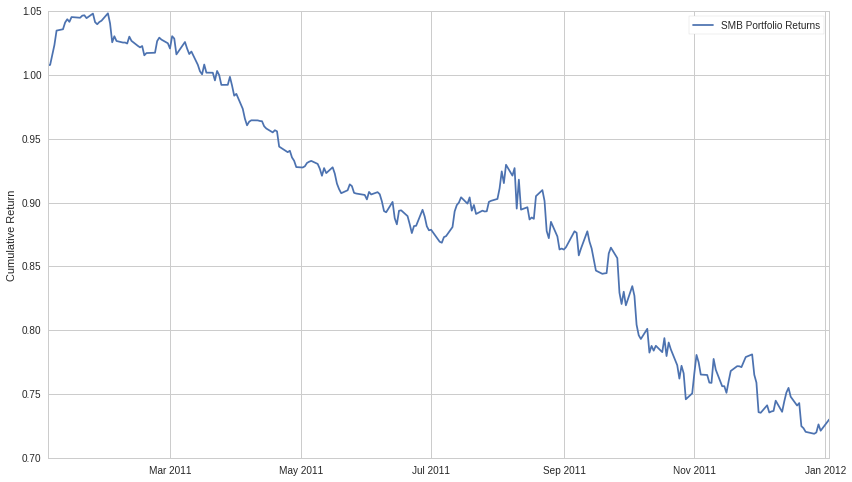

In [14]:
plt.plot(SMB.index, np.cumprod(SMB.values+1))
plt.ylabel('Cumulative Return')
plt.legend(['SMB Portfolio Returns']);

The last data we need are the daily returns on the broad market.

In [15]:
M = get_pricing('SPY', start_date='2011-1-1', end_date='2012-1-1', fields='price').pct_change()[1:]

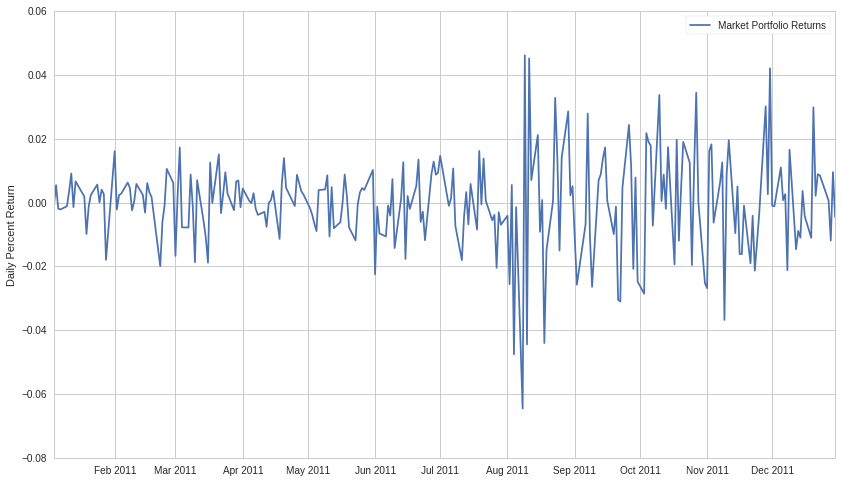

In [16]:
plt.plot(M.index, M.values)
plt.ylabel('Daily Percent Return')
plt.legend(['Market Portfolio Returns']);

###Actually Running the Regression

Now that we have returns series representing our factors, we can compute the factor model for any return stream using a linear regression. Below, we compute the factor sensitivities for returns on a tech portfolio.

In [17]:
# Get returns data for our portfolio
portfolio = get_pricing(['MSFT', 'AAPL', 'YHOO', 'FB', 'TSLA'], 
                        fields='price', start_date=start_date, end_date=end_date).pct_change()[1:]
R = np.mean(portfolio, axis=1)

Put all the data into one dataframe for convenience.

In [18]:
# Define a constant to compute intercept
constant = pd.TimeSeries(np.ones(len(R.index)), index=R.index)

df = pd.DataFrame({'R': R,
              'M': M,
              'SMB': SMB,
              'HML': HML,
              'Constant': constant})
df = df.dropna()

Perform the regression. You'll notice that these are the sensitivities over an entire year. It can be valuable to look at the rolling sensitivities as well to determine how stable they are.

In [19]:
# Perform linear regression to get the coefficients in the model
b1, b2, b3 = regression.linear_model.OLS(df['R'], df[['M', 'SMB', 'HML']]).fit().params

# Print the coefficients from the linear regression
print 'Historical Sensitivities of portfolio returns to factors:\nMarket: %f\nMarket cap: %f\nB/P: %f' %  (b1, b2, b3)

Historical Sensitivities of portfolio returns to factors:
Market: 0.961804
Market cap: -0.203828
B/P: 0.050790


Let's perform a rolling regression to look at how the estimated sensitivities change over time.

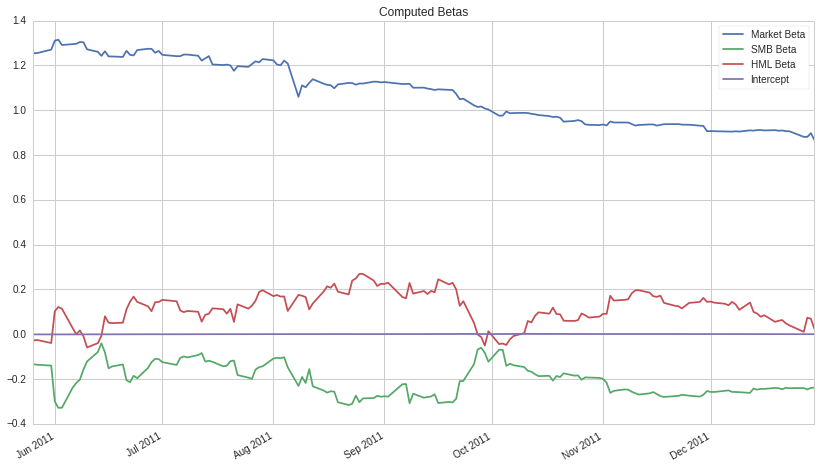

In [20]:
model = pd.stats.ols.MovingOLS(y = df['R'], x=df[['M', 'SMB', 'HML']], 
                             window_type='rolling', 
                             window=100)
rolling_parameter_estimates = model.beta
rolling_parameter_estimates.plot();
plt.title('Computed Betas');
plt.legend(['Market Beta', 'SMB Beta', 'HML Beta', 'Intercept']);

##Approach 2: Factor Value Normalization

###This is also known as cross-sectional factor analysis.

Another approach is to normalize factor values each bar and see how predictive of that bar's returns they were. We do this by computing a normalized factor value $b_{aj}$ for each asset $a$ in the following way. 

$$b_{aj} = \frac{F_{aj} - \mu_{F_j}}{\sigma_{F_j}}$$

$F_{aj}$ is the value of factor $j$ for asset $a$ during this bar, $\mu_{F_j}$ is the mean factor value across all assets, and $\sigma_{F_j}$ is the standard deviation of factor values over all assets. Notice that we are just computing a z-score to make asset specific factor values comparable across different factors.

The exceptions to this formula are indicator variables, which are set to 1 for true and 0 for false. One example is industry membership: the coefficient tells us whether the asset belongs to the industry or not. 

After we calculate all of the normalized scores during bar $t$, we can estimate factor $j$'s returns $F_{jt}$, using a cross-sectional regression (i.e. at each time step, we perform a regression using the equations for all of the assets). Specifically, once we have returns for each asset $R_{at}$, and normalized factor coefficients $b_{aj}$, we construct the following model and estimate the $F_j$s and $a_t$

$$R_{at} = a_t + b_{a1}F_1 + b_{a2}F_2 + \dots + b_{aK}F_K$$

You can think of this as slicing through the other direction from the first analysis, as now the factor returns are unknowns to be solved for, whereas originally the coefficients were the unknowns. Another way to think about it is that you're determining how predictive of returns the factor was on that day, and therefore how much return you could have squeezed out of that factor.

Following this procedure, we'll get the cross-sectional returns on 2011-01-03, and compute the coefficients for all assets:

###Getting the Data

We already have the results of the previous pipeline call, so we can grab book to price information for 2011-1-3 pretty easily.

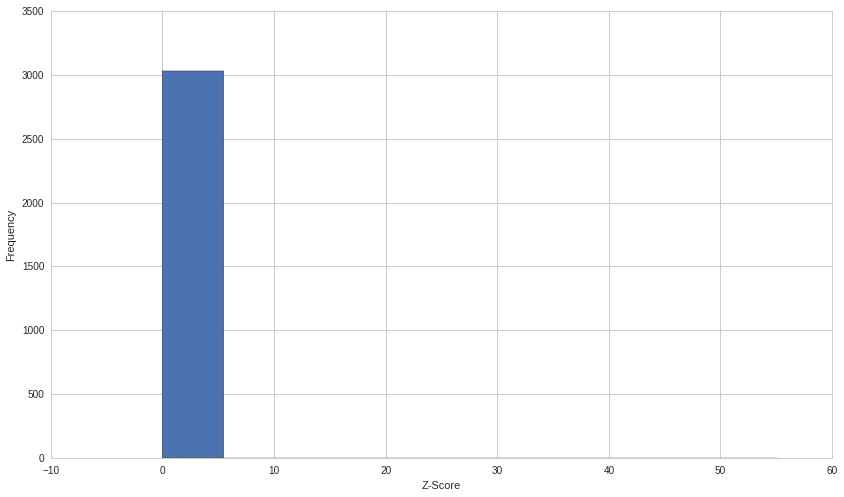

In [21]:
BTP = results['book_to_price'].loc['2011-1-3']
zscore = (BTP - np.mean(BTP)) / np.std(BTP)
zscore.dropna(inplace=True)

plt.hist(zscore)
plt.xlabel('Z-Score')
plt.ylabel('Frequency');

###Problem: The Data is Weirdly Distributed

Notice how there are big outliers in the dataset that cause the z-scores to lose a lot of information. Basically the presence of some huge book to price datapoints causes the rest of the data to seem to occupy a relatively small area. We need to get around this issue using some data cleaning technique, here we're use winsorization.

####Winsorization

Winzorization takes the top $n\%$ of a dataset and sets it all equal to the least extreme value in the top $n\%$. For example, if your dataset ranged from 0-10, plus a few crazy outliers, those outliers would be set to 0 or 10 depending on their direction. Here is an example.

In [22]:
# Get some random data
X = np.random.normal(0, 1, 100)

# Put in some outliers
X[0] = 1000
X[1] = -1000

# Perform winsorization
print 'Before winsorization', np.min(X), np.max(X)
scipy.stats.mstats.winsorize(X, inplace=True, limits=0.01)
print 'After winsorization', np.min(X), np.max(X)

Before winsorization -1000.0 1000.0
After winsorization -1.83229157134 3.06505673118


This looks good, let's see how our book to price data looks when winsorized.

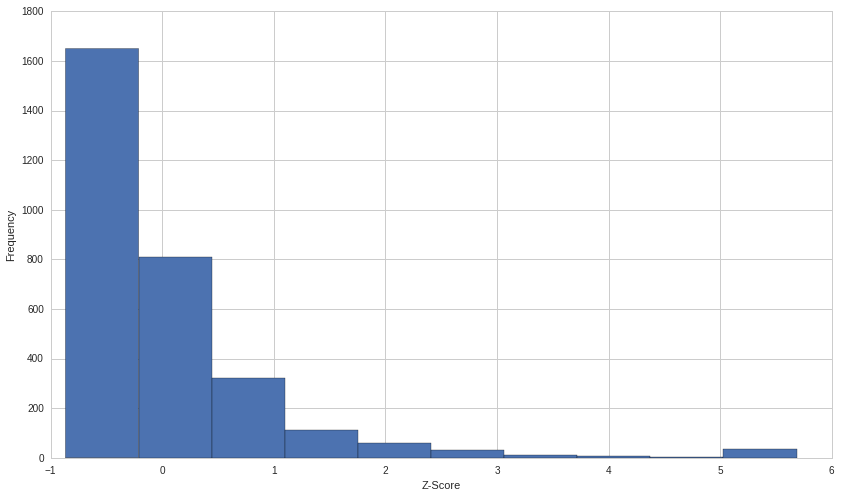

In [23]:
BTP = results['book_to_price'].loc['2011-1-3']
scipy.stats.mstats.winsorize(BTP, inplace=True, limits=0.01)
BTP_z = (BTP - np.mean(BTP)) / np.std(BTP)
BTP_z.dropna(inplace=True)

plt.hist(BTP_z)
plt.xlabel('Z-Score')
plt.ylabel('Frequency');

We need the returns for that day as well.

In [24]:
R_day = results['returns'].loc['2011-1-3']

Now set up our data and estimate $F_j$ using linear regression.

In [25]:
constant = pd.TimeSeries(np.ones(len(R_day.index)), index=R_day.index)

df_day = pd.DataFrame({'R': R_day,
              'BTP_z': BTP_z,
              'Constant': constant})
df_day = df_day.dropna()

# Perform linear regression to get the coefficients in the model
F1 = regression.linear_model.OLS(df_day['R'], df_day['BTP_z']).fit().params
print F1

BTP_z    0.002035
dtype: float64


Finally, let's add another factor so you can see how the code changes.

In [26]:
MKT = results['market_cap'].loc['2011-1-3']
scipy.stats.mstats.winsorize(MKT, inplace=True, limits=0.01)
MKT_z = (MKT - np.mean(MKT)) / np.std(MKT)

constant = pd.TimeSeries(np.ones(len(R_day.index)), index=R_day.index)

df_day = pd.DataFrame({'R': R_day,
              'BTP_z': BTP_z,
              'MKT_z': MKT_z,
              'Constant': constant})
df_day = df_day.dropna()

# Perform linear regression to get the coefficients in the model
F1, F2 = regression.linear_model.OLS(df_day['R'], df_day[['BTP_z', 'MKT_z']]).fit().params
print F1, F2

0.00201998732392 0.000131209827362


To expand this analysis, you would simply loop through days, running this every day and getting an estimated factor return.

##Using Fundamental Factor Modeling

###Returns Prediction

As discussed in the Arbitrage Price Theory lecture, factor modeling can be used to predict future returns based on current fundamental factors, or to determine when an asset may be mispriced. Modeling future returns is accomplished by offsetting the returns in the regression, so that rather than predicted for current returns, you are predicting for future returns. Once you have a predictive model, the most canonical way to create a strategy is to attempt a long-short equity approach.

There is a full lecture describing long-short equity, but the general idea is that you rank equities based on their predicted future returns. You then long the top p% and short the bottom p% remaining neutral on dollar volume. If the assets at the top of the ranking on average tend to make $5\%$ more per year than the market, and assets at the bottom tend to make $5\%$ less, then you will make $(M + 0.05) - (M - 0.05) = 0.10$ or $10\%$ percent per year, where $M$ is the market return that gets canceled out.

###Hedging out Exposure

Once we've determined that we are exposed to a factor, we may want to avoid depending on the performance of that factor by taking out a hedge. This is discussed in the Beta Hedging lecture and also in the Risk Factor Exposure notebook.